In [26]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Custom Dataset
class RegressionDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        df = pd.read_csv(f"{root_dir}{csv_file}", header=None, sep='\s+')
        self.features = df.iloc[:, 2:].astype(np.float32).values  # columns 2-40 (39 features)
        self.targets = df.iloc[:, [0,1]].astype(np.float32).values  # columns 0,1
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self, idx):
        X = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return X, y

# 2. Split and DataLoader
dataset = RegressionDataset(csv_file="Regression_train.csv",
                       root_dir='/content/sample_data/')
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_test = n_total - n_train
train_set, test_set = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_set, batch_size=20, shuffle=True)
test_loader = DataLoader(test_set, batch_size=20, shuffle=False)

# 3. Define MLP Model with 5 hidden layers, ReLU activation function
class MLPexperiment1(nn.Module):
    def __init__(self, input_dim=39, output_dim=2):
        super().__init__()
        # MLP with 5 hidden layer and ReLU
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64), #1 Hidden layer
            nn.ReLU(),
            nn.Linear(64, 128), #2 Hidden layer
            nn.ReLU(),
            nn.Linear(128, 128), #3 Hidden layer
            nn.ReLU(),
            nn.Linear(128, 128), #4 Hidden layer
            nn.ReLU(),
            nn.Linear(128, 32), #5 Hidden layer
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

# 3. Define MLP Model with 3 hidden layer, ReLU activation function
class MLPexperiment2(nn.Module):
    def __init__(self, input_dim=39, output_dim=2):
        super().__init__()
        # MLP with 5 hidden layer and ReLU
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64), #1 Hidden layer
            nn.ReLU(),
            nn.Linear(64, 64), #2 Hidden layer
            nn.ReLU(),
            nn.Linear(64, 32), #3 Hidden layer
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

# 3. Define MLP Model with 3 hidden layers, Tanh activation function
class MLPexperiment3(nn.Module):
    def __init__(self, input_dim=39, output_dim=2):
        super().__init__()
        # MLP with 5 hidden layer and ReLU
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64), #1 Hidden layer
            nn.Sigmoid(),
            nn.Linear(64, 64), #2 Hidden layer
            nn.Sigmoid(),
            nn.Linear(64, 32), #3 Hidden layer
            nn.Sigmoid(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

# 4. Training Functions
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)

# 5. Evaluation function
def eval_model(model, loader):
    model.eval()
    preds, trues = [], []
    total_loss = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            total_loss += loss.item() * X.size(0)
            preds.append(pred.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    return total_loss / len(loader.dataset), preds, trues

# 6. Training Loops and loss, error dump
def train_loop(model, train_loader, test_loader, n_epochs ):
    import matplotlib.pyplot as plt
    n_epochs = 100
    loss = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader)
        test_loss, y_pred, y_true = eval_model(model, test_loader)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        loss.append(mse)
#        print(f"Epoch {epoch+1}/{n_epochs}")
    plt.plot(loss)
    plt.show()

    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Test Loss:  {test_loss:.4f}")
    print(f"  MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R^2: {r2:.4f}")
    return y_pred, y_true


# 7. Plot Actual vs Predicted for each target
def plotActualVsPredicted(y_true, y_pred):
    import matplotlib.pyplot as plt
    for i in range(2):
        plt.figure()
        plt.scatter(y_true[:,i], y_pred[:,i], alpha=0.5)
        plt.plot([y_true[:,i].min(), y_true[:,i].max()],
                [y_true[:,i].min(), y_true[:,i].max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Actual vs Predicted for Target {i+1}')
        plt.grid(True)
        plt.show()



Experiment 1: ActivationFn=ReLU, Hidden Layer=5


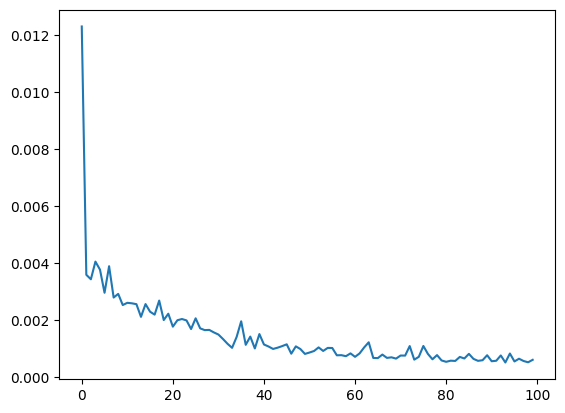

Epoch 100/100
  Train Loss: 0.0005
  Test Loss:  0.0006
  MSE: 0.0006 | RMSE: 0.0246 | MAE: 0.0138 | R^2: 0.9333


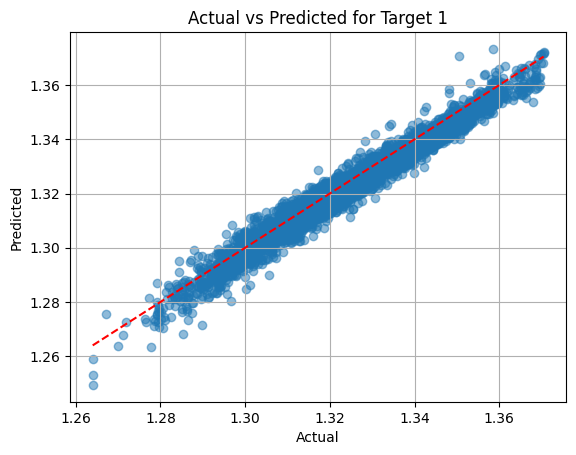

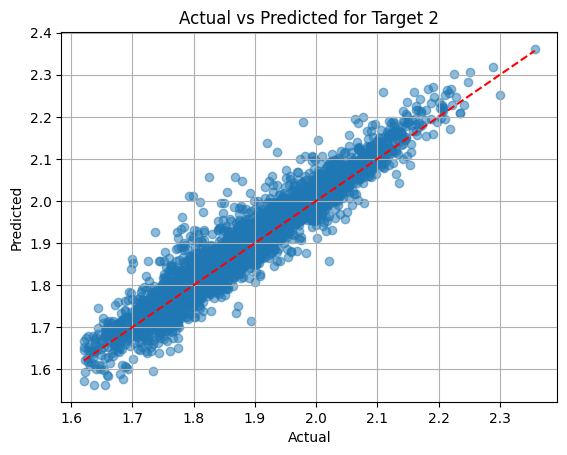

In [27]:
# Experiment 1: ActivationFn=ReLU, Hidden Layer=5, LR=0.001, Batch 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPexperiment1(input_dim=39, output_dim=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(f"Experiment 1: ActivationFn=ReLU, Hidden Layer=5 Batch=20")
y_pred, y_true = train_loop(model, train_loader, test_loader, 50)
plotActualVsPredicted(y_pred, y_true)
# save your model
torch.save(model, 'model1_lr001_RelU_HiddenLayer5_Batch20.pth')

Experiment 2: ActivationFn=ReLU, Hidden Layer=3 Batch=20


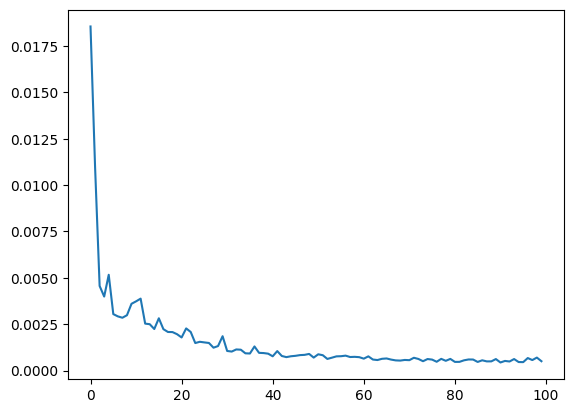

Epoch 100/100
  Train Loss: 0.0005
  Test Loss:  0.0005
  MSE: 0.0005 | RMSE: 0.0225 | MAE: 0.0129 | R^2: 0.9483


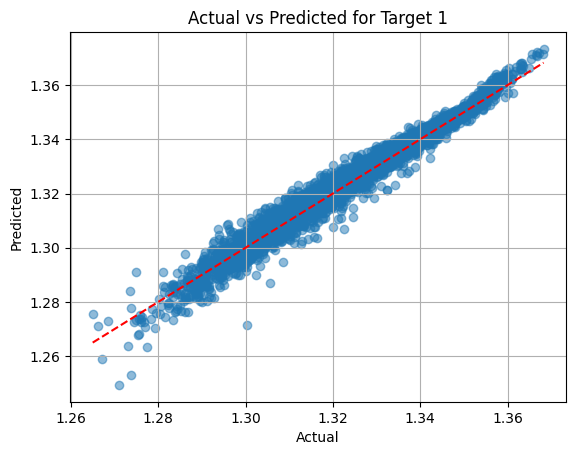

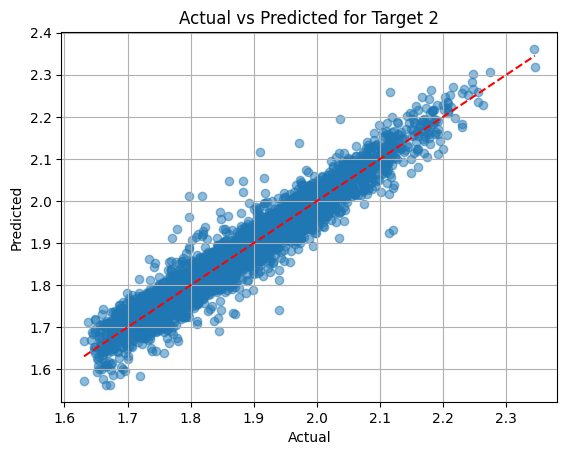

In [28]:
# Experiment 2: ActivationFn=ReLU, Hidden Layer=3, LR=0.001, Batch 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPexperiment2(input_dim=39, output_dim=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(f"Experiment 2: ActivationFn=ReLU, Hidden Layer=3 Batch=20")
y_pred, y_true = train_loop(model, train_loader, test_loader, 50)
plotActualVsPredicted(y_pred, y_true)
# save your model
torch.save(model, 'model2_lr001_RelU_HiddenLayer3_Batch20.pth')

Experiment 3: ActivationFn=Sigmoid, Hidden Layer=3 Batch=20


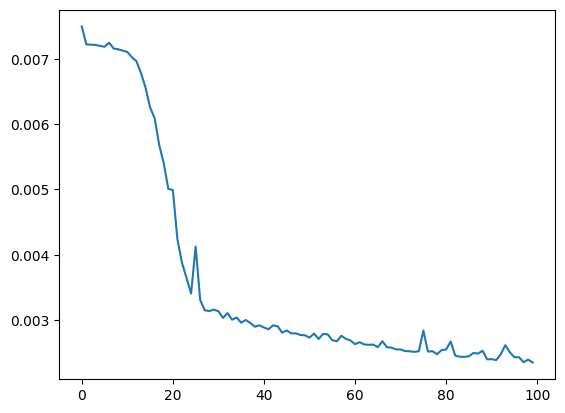

Epoch 100/100
  Train Loss: 0.0023
  Test Loss:  0.0024
  MSE: 0.0024 | RMSE: 0.0485 | MAE: 0.0294 | R^2: 0.7577


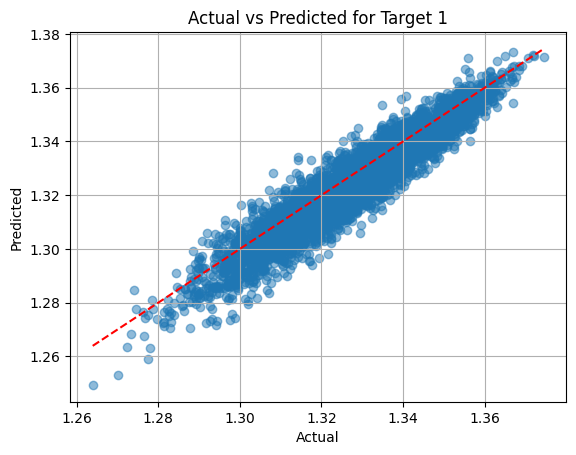

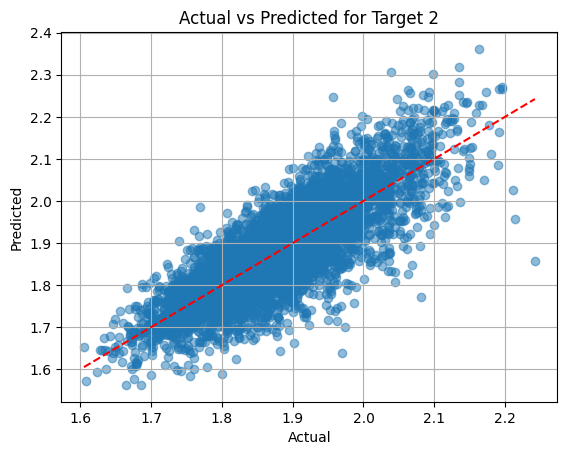

In [29]:
# Experiment 3: ActivationFn=Sigmoid, Hidden Layer=3, LR=0.001, Batch 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPexperiment3(input_dim=39, output_dim=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(f"Experiment 3: ActivationFn=Sigmoid, Hidden Layer=3 Batch=20")
y_pred, y_true = train_loop(model, train_loader, test_loader, 50)
plotActualVsPredicted(y_pred, y_true)
# save your model
torch.save(model, 'model3_lr001_Sigmoid_HiddenLayer3_Batch20.pth')

In [21]:
# 7. Training Loops and loss, error dump
def eval_loop(model, test_loader, n_epochs ):
    import matplotlib.pyplot as plt
    n_epochs = 100
    loss = []
    for epoch in range(n_epochs):
        test_loss, y_pred, y_true = eval_model(model, test_loader)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

    print(f"Epoch {epoch+1}/{n_epochs}")
#    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Test Loss:  {test_loss:.4f}")
    print(f"  MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R^2: {r2:.4f}")
    return y_pred, y_true



In [24]:
dataset = RegressionDataset(csv_file="test_Regression.csv",
                       root_dir='/content/sample_data/')

test_loader_eval = DataLoader(dataset, batch_size=1, shuffle=False)

Experiment 1 EVAL: ActivationFn=ReLU, Hidden Layer=5 LR=0.001
Epoch 100/100
  Test Loss:  0.0006
  MSE: 0.0006 | RMSE: 0.0237 | MAE: 0.0136 | R^2: 0.9448


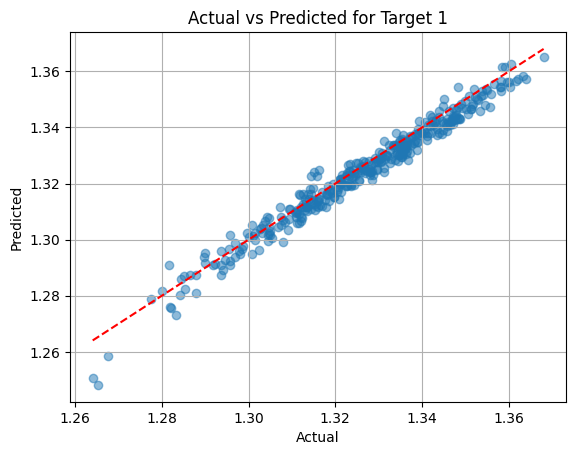

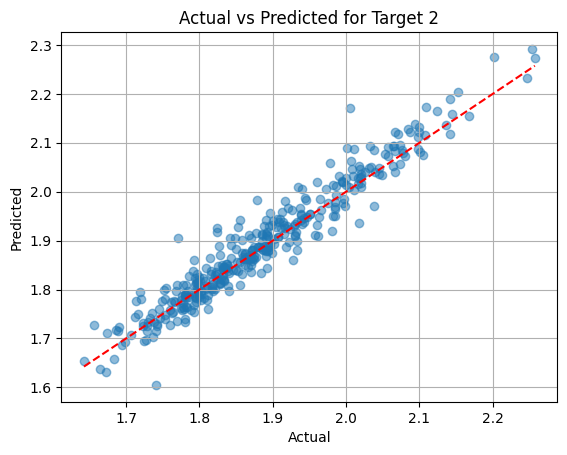

In [35]:
# Experiment 1: load and evaluate the model model1_lr001_RelU_HiddenLayer5_Batch20

model_eval = torch.load('model1_lr001_RelU_HiddenLayer5_Batch20.pth', weights_only=False)

print(f"Experiment 1 EVAL: ActivationFn=ReLU, Hidden Layer=5 LR=0.001")
y_pred, y_true = eval_loop(model_eval, test_loader_eval, 50)
plotActualVsPredicted(y_pred, y_true)

Experiment 2 EVAL: ActivationFn=RelU, Hidden Layer=3 LR=0.001
Epoch 100/100
  Test Loss:  0.0005
  MSE: 0.0005 | RMSE: 0.0232 | MAE: 0.0133 | R^2: 0.9499


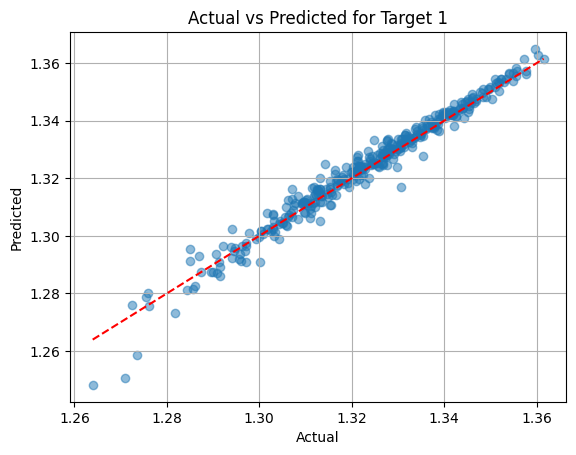

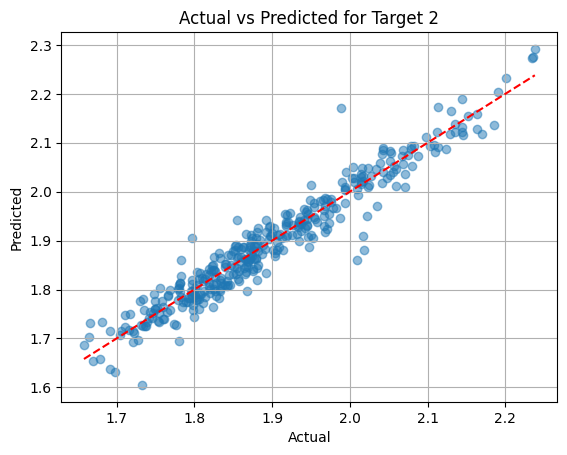

In [32]:
# Experiment 2: load and evaluate the model model2_lr001_RelU_HiddenLayer3_Batch20

model_eval = torch.load('model2_lr001_RelU_HiddenLayer3_Batch20.pth', weights_only=False)
print(f"Experiment 2 EVAL: ActivationFn=RelU, Hidden Layer=3 LR=0.001")

y_pred, y_true = eval_loop(model_eval, test_loader_eval, 50)
plotActualVsPredicted(y_pred, y_true)

Experiment 3 EVAL: ActivationFn=Sigmoid, Hidden Layer=3 LR=0.0001
Epoch 100/100
  Test Loss:  0.0024
  MSE: 0.0024 | RMSE: 0.0488 | MAE: 0.0295 | R^2: 0.7806


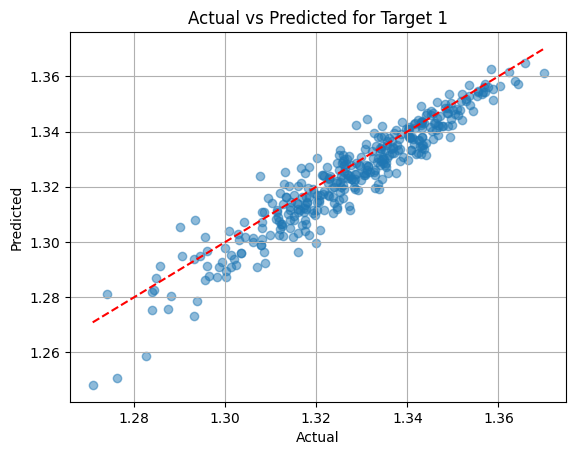

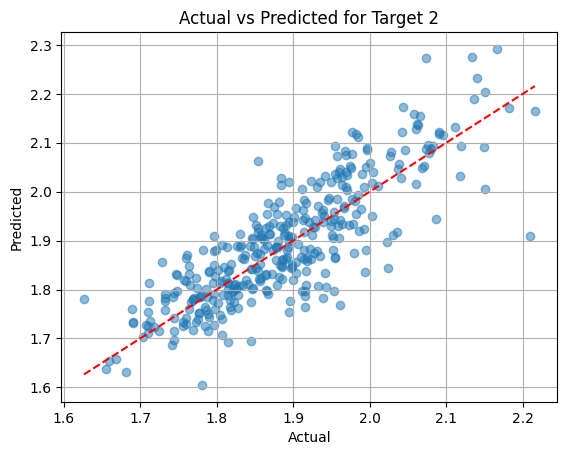

In [34]:
# Experiment 3: load and evaluate the model model3_lr0001_Sigmoid_HiddenLayer3_Batch20

model_eval = torch.load('model3_lr0001_Sigmoid_HiddenLayer3_Batch20.pth', weights_only=False)
print(f"Experiment 3 EVAL: ActivationFn=Sigmoid, Hidden Layer=3 LR=0.0001")

y_pred, y_true = eval_loop(model_eval, test_loader_eval, 50)
plotActualVsPredicted(y_pred, y_true)